# **Pneumonia Detection**
**A machine learning project for detecting pneumonia from chest X-ray images using transfer learning and model tuning techniques.**

## **Pretrained Model Tuning**

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### **Dataset Preparation**
We'll create a custom dataset class to handle our X-ray images and apply appropriate transformations for transfer learning.

In [3]:
# Import data loading function
from _data import load_pneumonia_1d


class PneumoniaDataset(Dataset):
  def __init__(self, features, labels, transform=None):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = self.features[idx]
    label = self.labels[idx]

    # Convert to tensor if not already
    if not torch.is_tensor(image):
      image = torch.tensor(image, dtype=torch.float32)

    # Reshape to (1, 224, 224) if necessary
    if image.shape != (1, 224, 224):
      image = image.reshape(1, 224, 224)

    # Apply transformations if any
    if self.transform:
      image = self.transform(image)

    return image, label

### **Data Loading & Transformation**
Define the transformations needed for pretrained models and load our dataset.

In [4]:
# Define transformations for transfer learning
train_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB (needed for pretrained models that expect 3 channels)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Data augmentation
    transforms.RandomHorizontalFlip(),  # Horizontal flips are safe for chest X-rays
    transforms.RandomRotation(5),  # Small rotation angle
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small translations
    # Normalize using ImageNet stats (required for pretrained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

test_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Normalize using ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

# Load data
train_data, test_data = load_pneumonia_1d(
  include_raw=True, include_hog=False, include_lbp=False, pca_mode="none"
)

# Split features and labels
X_train = train_data[:, :-1].reshape(-1, 1, 224, 224)
y_train = train_data[:, -1]
X_test = test_data[:, :-1].reshape(-1, 1, 224, 224)
y_test = test_data[:, -1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = PneumoniaDataset(X_train, y_train, transform=train_transforms)
test_dataset = PneumoniaDataset(X_test, y_test, transform=test_transforms)

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Training Utilities**
Define helper functions for the training process.

In [5]:
def make_train_step(model, optimizer, loss_fn):
  """
  Create a single training step function to update model parameters
  """

  def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

  return train_step


def evaluate_model(model, dataloader, loss_fn, device):
  """
  Evaluate the model on the given dataloader
  """
  model.eval()
  all_preds = []
  all_targets = []
  cum_loss = 0
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      yhat = model(x_batch)
      val_loss = loss_fn(yhat, y_batch)
      cum_loss += val_loss.item() / len(dataloader)

      # Convert logits to predictions
      probs = torch.sigmoid(yhat)
      preds = torch.round(probs)

      all_preds.append(preds.cpu())
      all_targets.append(y_batch.cpu())

  # Combine all batches
  all_preds = torch.cat(all_preds).numpy()
  all_targets = torch.cat(all_targets).numpy()

  # Compute metrics
  metrics = {
    "loss": cum_loss,
    "accuracy": accuracy_score(all_targets, all_preds),
    "precision": precision_score(all_targets, all_preds),
    "recall": recall_score(all_targets, all_preds),
    "f1": f1_score(all_targets, all_preds),
    "predictions": all_preds,
    "targets": all_targets,
  }

  return metrics


def plot_metrics(train_losses, val_losses, val_metrics, title_prefix="Model"):
  """
  Plot training and validation metrics
  """
  plt.figure(figsize=(15, 10))

  # Plot losses
  plt.subplot(2, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"{title_prefix} - Loss over Epochs")
  plt.legend()
  plt.grid(True)

  # Plot accuracy
  plt.subplot(2, 2, 2)
  plt.plot([metrics["accuracy"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f"{title_prefix} - Validation Accuracy")
  plt.grid(True)

  # Plot F1 score
  plt.subplot(2, 2, 3)
  plt.plot([metrics["f1"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.title(f"{title_prefix} - Validation F1 Score")
  plt.grid(True)

  # Plot precision and recall
  plt.subplot(2, 2, 4)
  plt.plot([metrics["precision"] for metrics in val_metrics], label="Precision")
  plt.plot([metrics["recall"] for metrics in val_metrics], label="Recall")
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title(f"{title_prefix} - Validation Precision and Recall")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  """
  Plot confusion matrix
  """
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  plt.figure(figsize=(8, 8))
  disp.plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.show()

### **Model Architecture**
Load pretrained models and modify them for our pneumonia classification task.

In [ ]:
def create_resnet_model():
  """
  Create a ResNet18 model with pretrained weights
  """
  # Load pretrained ResNet18
  model = torchvision.models.resnet18(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_densenet_model():
  """
  Create a DenseNet121 model with pretrained weights
  """
  # Load pretrained DenseNet121
  model = torchvision.models.densenet121(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_efficientnet_model():
  """
  Create an EfficientNet-B0 model with pretrained weights
  """
  # Load pretrained EfficientNet B0
  model = torchvision.models.efficientnet_b0(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the classifier for binary classification
  num_ftrs = model.classifier[1].in_features
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), nn.Linear(num_ftrs, 1)
  )

  return model.to(device)


def create_vit_model():
  """
  Create a Vision Transformer (ViT) model with pretrained weights
  """
  # Load pretrained ViT-B/16
  model = torchvision.models.vit_b_16(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.heads.head.in_features
  model.heads.head = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_swin_model():
  """
  Create a Swin Transformer model with pretrained weights
  """
  # Load pretrained Swin-T
  model = torchvision.models.swin_t(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.head.in_features
  model.head = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_convnext_model():
  """
  Create a ConvNeXt model with pretrained weights
  """
  # Load pretrained ConvNeXt-T
  model = torchvision.models.convnext_tiny(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.classifier[2].in_features
  model.classifier = nn.Sequential(
    nn.Flatten(1), nn.LayerNorm([num_ftrs]), nn.Linear(num_ftrs, 1)
  )

  return model.to(device)

### **Training Loop**
Define the training process with early stopping and learning rate scheduling.

In [7]:
def train_model(
  model, trainloader, testloader, model_name="Model", n_epochs=20, patience=3
):
  """
  Train the model with early stopping and learning rate scheduling
  """
  # Calculate class weights for balanced loss
  y_train_np = y_train.cpu().numpy()
  class_weights = compute_class_weight(
    "balanced", classes=np.array([0, 1]), y=y_train_np.flatten()
  )
  pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)
  print(f"Class weights: {class_weights}")
  print(f"Positive class weight: {pos_weight.item()}")

  # Loss function and optimizer
  loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
  optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
  )
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.5
  )

  # Training step function
  train_step = make_train_step(model, optimizer, loss_fn)

  # Initialize tracking variables
  best_loss = float("inf")
  early_stopping_counter = 0
  best_model_weights = None

  train_losses = []
  val_losses = []
  val_metrics_history = []

  # Training loop
  for epoch in range(n_epochs):
    # Training phase
    epoch_loss = 0
    for i, data in tqdm(
      enumerate(trainloader),
      total=len(trainloader),
      desc=f"Epoch {epoch + 1}/{n_epochs}",
    ):
      x_batch, y_batch = data
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      loss = train_step(x_batch, y_batch)
      epoch_loss += loss / len(trainloader)

    train_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    val_metrics = evaluate_model(model, testloader, loss_fn, device)
    val_loss = val_metrics["loss"]
    val_losses.append(val_loss)
    val_metrics_history.append(val_metrics)

    print(
      f"Validation Loss: {val_loss:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, "
      f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, "
      f"F1 Score: {val_metrics['f1']:.4f}"
    )

    # Update learning rate
    scheduler.step(val_loss)

    # Check for improvement and early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_weights = model.state_dict().copy()
      early_stopping_counter = 0
      print(f"New best validation loss: {best_loss:.4f}")
    else:
      early_stopping_counter += 1
      print(f"No improvement for {early_stopping_counter} epochs")

    if early_stopping_counter >= patience:
      print("Early stopping triggered")
      break

  # Load best model weights
  if best_model_weights:
    model.load_state_dict(best_model_weights)
    print(f"Loaded best model with validation loss: {best_loss:.4f}")

  # Final evaluation
  final_metrics = evaluate_model(model, testloader, loss_fn, device)
  print("\n=== Final Model Evaluation ===")
  print(f"Loss: {final_metrics['loss']:.4f}")
  print(f"Accuracy: {final_metrics['accuracy']:.4f}")
  print(f"Precision: {final_metrics['precision']:.4f}")
  print(f"Recall: {final_metrics['recall']:.4f}")
  print(f"F1 Score: {final_metrics['f1']:.4f}")

  # Plot metrics
  plot_metrics(train_losses, val_losses, val_metrics_history, title_prefix=model_name)

  # Plot confusion matrix
  plot_confusion_matrix(
    final_metrics["targets"],
    final_metrics["predictions"],
    title=f"{model_name} - Confusion Matrix",
  )

  return model, final_metrics

### **Model Tuning: ResNet18**
Train and evaluate a fine-tuned ResNet18 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [02:38<00:00,  1.03it/s]


Epoch 1/20, Training Loss: 0.2011
Validation Loss: 0.2219, Accuracy: 0.8654, Precision: 0.9158, Recall: 0.8641, F1 Score: 0.8892
New best validation loss: 0.2219


Epoch 2/20: 100%|██████████| 164/164 [02:12<00:00,  1.24it/s]


Epoch 2/20, Training Loss: 0.1304
Validation Loss: 0.2091, Accuracy: 0.8750, Precision: 0.9171, Recall: 0.8795, F1 Score: 0.8979
New best validation loss: 0.2091


Epoch 3/20: 100%|██████████| 164/164 [02:04<00:00,  1.32it/s]


Epoch 3/20, Training Loss: 0.1122
Validation Loss: 0.2100, Accuracy: 0.8862, Precision: 0.9186, Recall: 0.8974, F1 Score: 0.9079
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [02:03<00:00,  1.32it/s]


Epoch 4/20, Training Loss: 0.1123
Validation Loss: 0.2009, Accuracy: 0.8814, Precision: 0.9225, Recall: 0.8846, F1 Score: 0.9031
New best validation loss: 0.2009


Epoch 5/20: 100%|██████████| 164/164 [02:04<00:00,  1.32it/s]


Epoch 5/20, Training Loss: 0.0998
Validation Loss: 0.2309, Accuracy: 0.8862, Precision: 0.8938, Recall: 0.9282, F1 Score: 0.9107
No improvement for 1 epochs


Epoch 6/20: 100%|██████████| 164/164 [02:04<00:00,  1.32it/s]


Epoch 6/20, Training Loss: 0.0985
Validation Loss: 0.2359, Accuracy: 0.8846, Precision: 0.8916, Recall: 0.9282, F1 Score: 0.9095
No improvement for 2 epochs


Epoch 7/20: 100%|██████████| 164/164 [02:05<00:00,  1.31it/s]


Epoch 7/20, Training Loss: 0.0917
Validation Loss: 0.2193, Accuracy: 0.8926, Precision: 0.9130, Recall: 0.9154, F1 Score: 0.9142
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2009

=== Final Model Evaluation ===
Loss: 0.2193
Accuracy: 0.8926
Precision: 0.9130
Recall: 0.9154
F1 Score: 0.9142


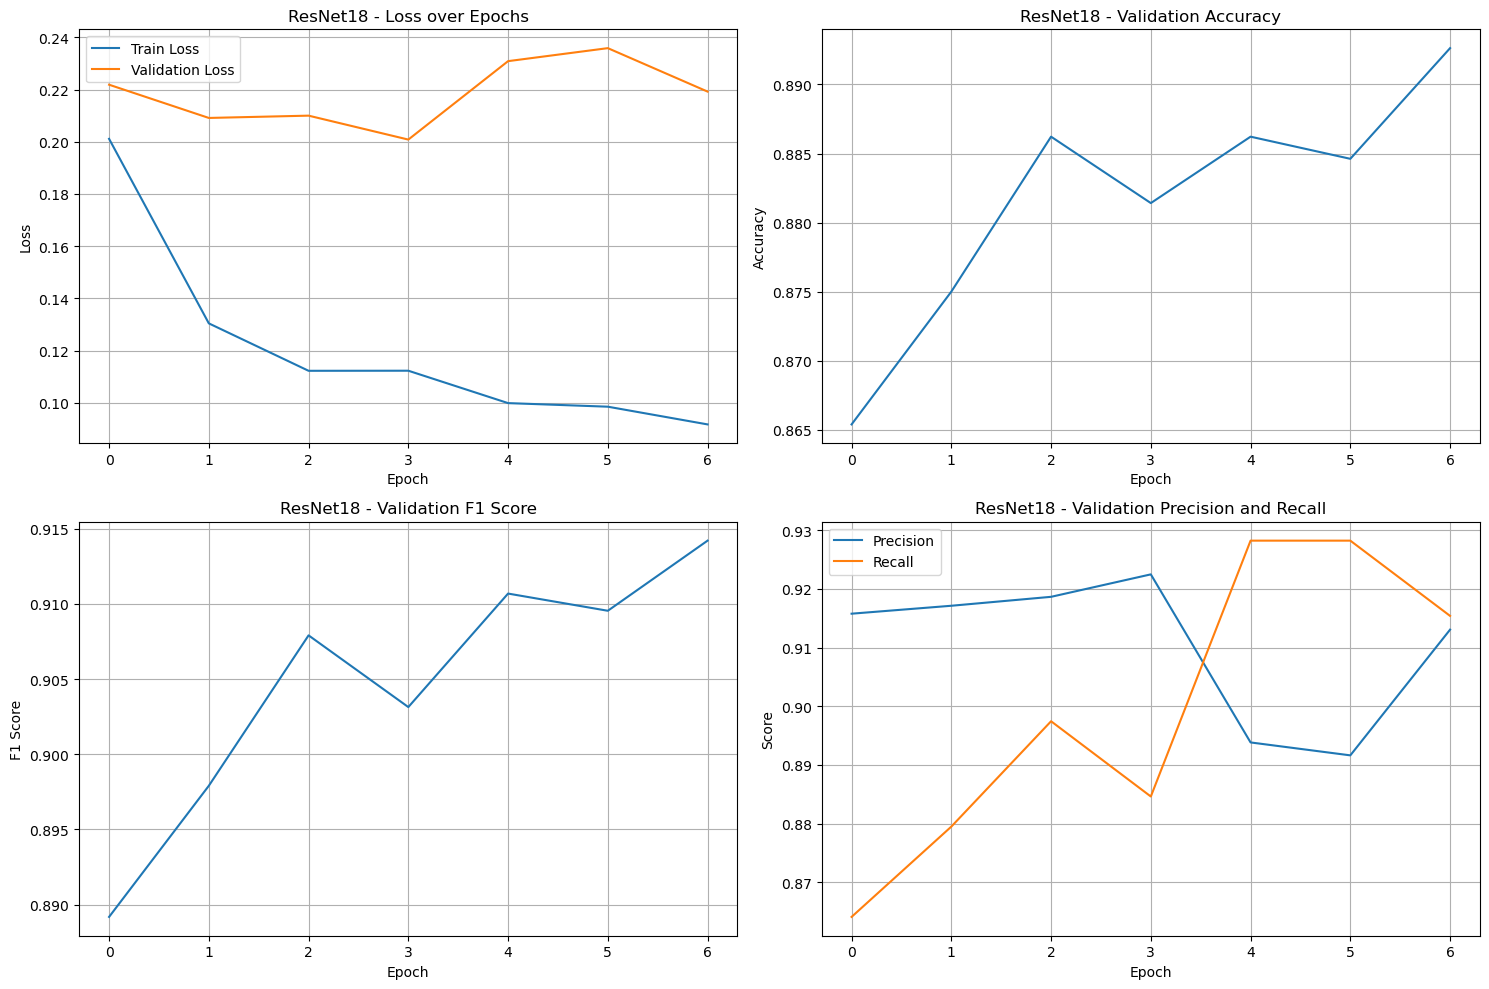

<Figure size 800x800 with 0 Axes>

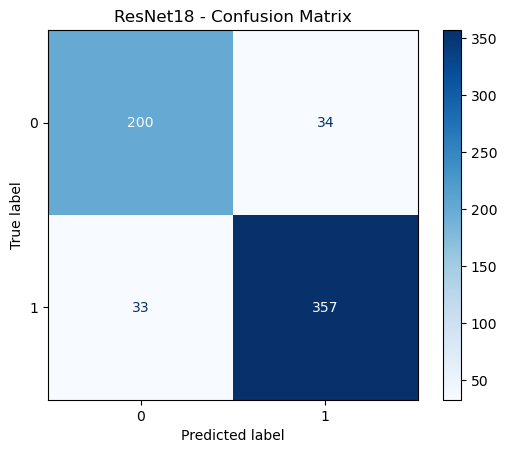

In [11]:
# Create and train ResNet18 model
resnet_model = create_resnet_model()
resnet_model, resnet_metrics = train_model(
  resnet_model, trainloader, testloader, model_name="ResNet18"
)

### **Model Tuning: DenseNet121**
Train and evaluate a fine-tuned DenseNet121 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [07:57<00:00,  2.91s/it]


Epoch 1/20, Training Loss: 0.2033
Validation Loss: 0.2230, Accuracy: 0.8125, Precision: 0.9389, Recall: 0.7487, F1 Score: 0.8331
New best validation loss: 0.2230


Epoch 2/20: 100%|██████████| 164/164 [08:18<00:00,  3.04s/it]


Epoch 2/20, Training Loss: 0.1347
Validation Loss: 0.2135, Accuracy: 0.8798, Precision: 0.9070, Recall: 0.9000, F1 Score: 0.9035
New best validation loss: 0.2135


Epoch 3/20: 100%|██████████| 164/164 [07:57<00:00,  2.91s/it]


Epoch 3/20, Training Loss: 0.1119
Validation Loss: 0.1947, Accuracy: 0.8766, Precision: 0.9129, Recall: 0.8872, F1 Score: 0.8999
New best validation loss: 0.1947


Epoch 4/20: 100%|██████████| 164/164 [08:00<00:00,  2.93s/it]


Epoch 4/20, Training Loss: 0.1010
Validation Loss: 0.2140, Accuracy: 0.8910, Precision: 0.8946, Recall: 0.9359, F1 Score: 0.9148
No improvement for 1 epochs


Epoch 5/20: 100%|██████████| 164/164 [07:51<00:00,  2.88s/it]


Epoch 5/20, Training Loss: 0.1016
Validation Loss: 0.2079, Accuracy: 0.8878, Precision: 0.9000, Recall: 0.9231, F1 Score: 0.9114
No improvement for 2 epochs


Epoch 6/20: 100%|██████████| 164/164 [07:56<00:00,  2.91s/it]


Epoch 6/20, Training Loss: 0.0921
Validation Loss: 0.2262, Accuracy: 0.8782, Precision: 0.8792, Recall: 0.9333, F1 Score: 0.9055
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.1947

=== Final Model Evaluation ===
Loss: 0.2262
Accuracy: 0.8782
Precision: 0.8792
Recall: 0.9333
F1 Score: 0.9055


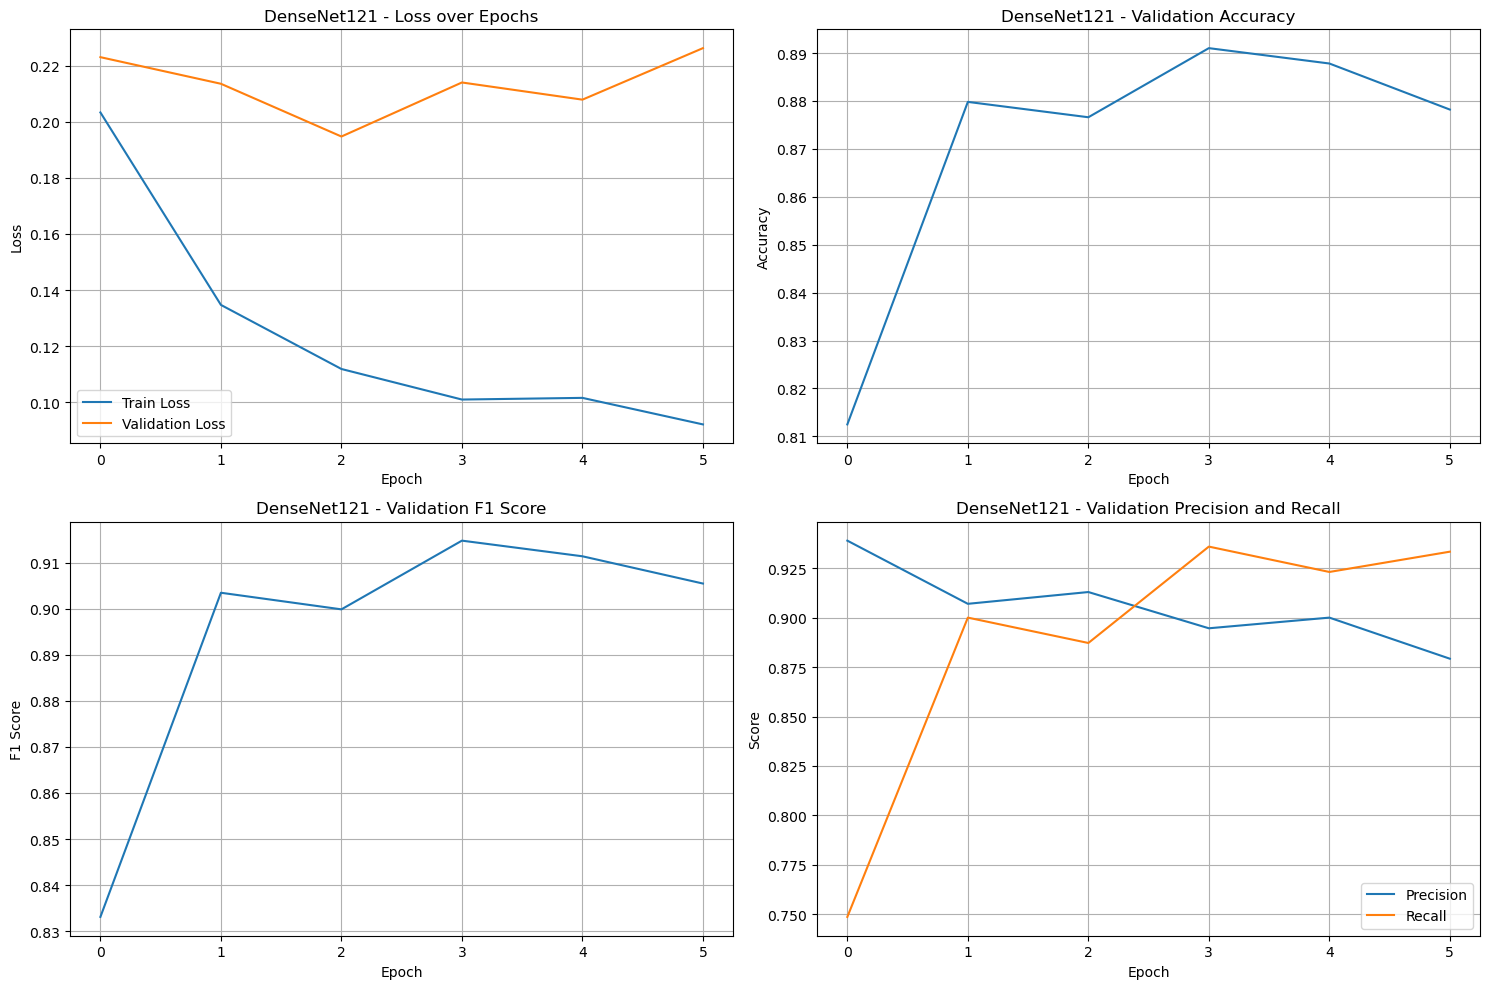

<Figure size 800x800 with 0 Axes>

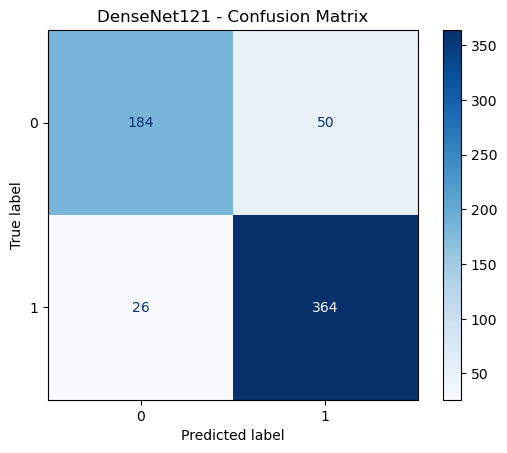

In [12]:
# Create and train DenseNet121 model
densenet_model = create_densenet_model()
densenet_model, densenet_metrics = train_model(
  densenet_model, trainloader, testloader, model_name="DenseNet121"
)

### **Model Tuning: EfficientNet-B0**
Train and evaluate a fine-tuned EfficientNet-B0 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [05:06<00:00,  1.87s/it]


Epoch 1/20, Training Loss: 0.1954
Validation Loss: 0.2415, Accuracy: 0.8590, Precision: 0.8872, Recall: 0.8872, F1 Score: 0.8872
New best validation loss: 0.2415


Epoch 2/20: 100%|██████████| 164/164 [05:01<00:00,  1.84s/it]


Epoch 2/20, Training Loss: 0.1243
Validation Loss: 0.2500, Accuracy: 0.8606, Precision: 0.8704, Recall: 0.9128, F1 Score: 0.8911
No improvement for 1 epochs


Epoch 3/20: 100%|██████████| 164/164 [05:03<00:00,  1.85s/it]


Epoch 3/20, Training Loss: 0.1127
Validation Loss: 0.2201, Accuracy: 0.8734, Precision: 0.8977, Recall: 0.9000, F1 Score: 0.8988
New best validation loss: 0.2201


Epoch 4/20: 100%|██████████| 164/164 [05:07<00:00,  1.87s/it]


Epoch 4/20, Training Loss: 0.1011
Validation Loss: 0.2186, Accuracy: 0.8718, Precision: 0.8995, Recall: 0.8949, F1 Score: 0.8972
New best validation loss: 0.2186


Epoch 5/20: 100%|██████████| 164/164 [05:03<00:00,  1.85s/it]


Epoch 5/20, Training Loss: 0.0965
Validation Loss: 0.2261, Accuracy: 0.8798, Precision: 0.8987, Recall: 0.9103, F1 Score: 0.9045
No improvement for 1 epochs


Epoch 6/20: 100%|██████████| 164/164 [05:06<00:00,  1.87s/it]


Epoch 6/20, Training Loss: 0.1012
Validation Loss: 0.2121, Accuracy: 0.8830, Precision: 0.9117, Recall: 0.9000, F1 Score: 0.9058
New best validation loss: 0.2121


Epoch 7/20: 100%|██████████| 164/164 [05:05<00:00,  1.86s/it]


Epoch 7/20, Training Loss: 0.0898
Validation Loss: 0.2439, Accuracy: 0.8814, Precision: 0.8835, Recall: 0.9333, F1 Score: 0.9077
No improvement for 1 epochs


Epoch 8/20: 100%|██████████| 164/164 [05:12<00:00,  1.91s/it]


Epoch 8/20, Training Loss: 0.0886
Validation Loss: 0.2083, Accuracy: 0.8910, Precision: 0.9107, Recall: 0.9154, F1 Score: 0.9130
New best validation loss: 0.2083


Epoch 9/20: 100%|██████████| 164/164 [05:02<00:00,  1.84s/it]


Epoch 9/20, Training Loss: 0.0922
Validation Loss: 0.2221, Accuracy: 0.8862, Precision: 0.8997, Recall: 0.9205, F1 Score: 0.9100
No improvement for 1 epochs


Epoch 10/20: 100%|██████████| 164/164 [05:02<00:00,  1.84s/it]


Epoch 10/20, Training Loss: 0.0895
Validation Loss: 0.2295, Accuracy: 0.8846, Precision: 0.8975, Recall: 0.9205, F1 Score: 0.9089
No improvement for 2 epochs


Epoch 11/20: 100%|██████████| 164/164 [05:05<00:00,  1.87s/it]


Epoch 11/20, Training Loss: 0.0890
Validation Loss: 0.2236, Accuracy: 0.8894, Precision: 0.9105, Recall: 0.9128, F1 Score: 0.9117
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2083

=== Final Model Evaluation ===
Loss: 0.2236
Accuracy: 0.8894
Precision: 0.9105
Recall: 0.9128
F1 Score: 0.9117


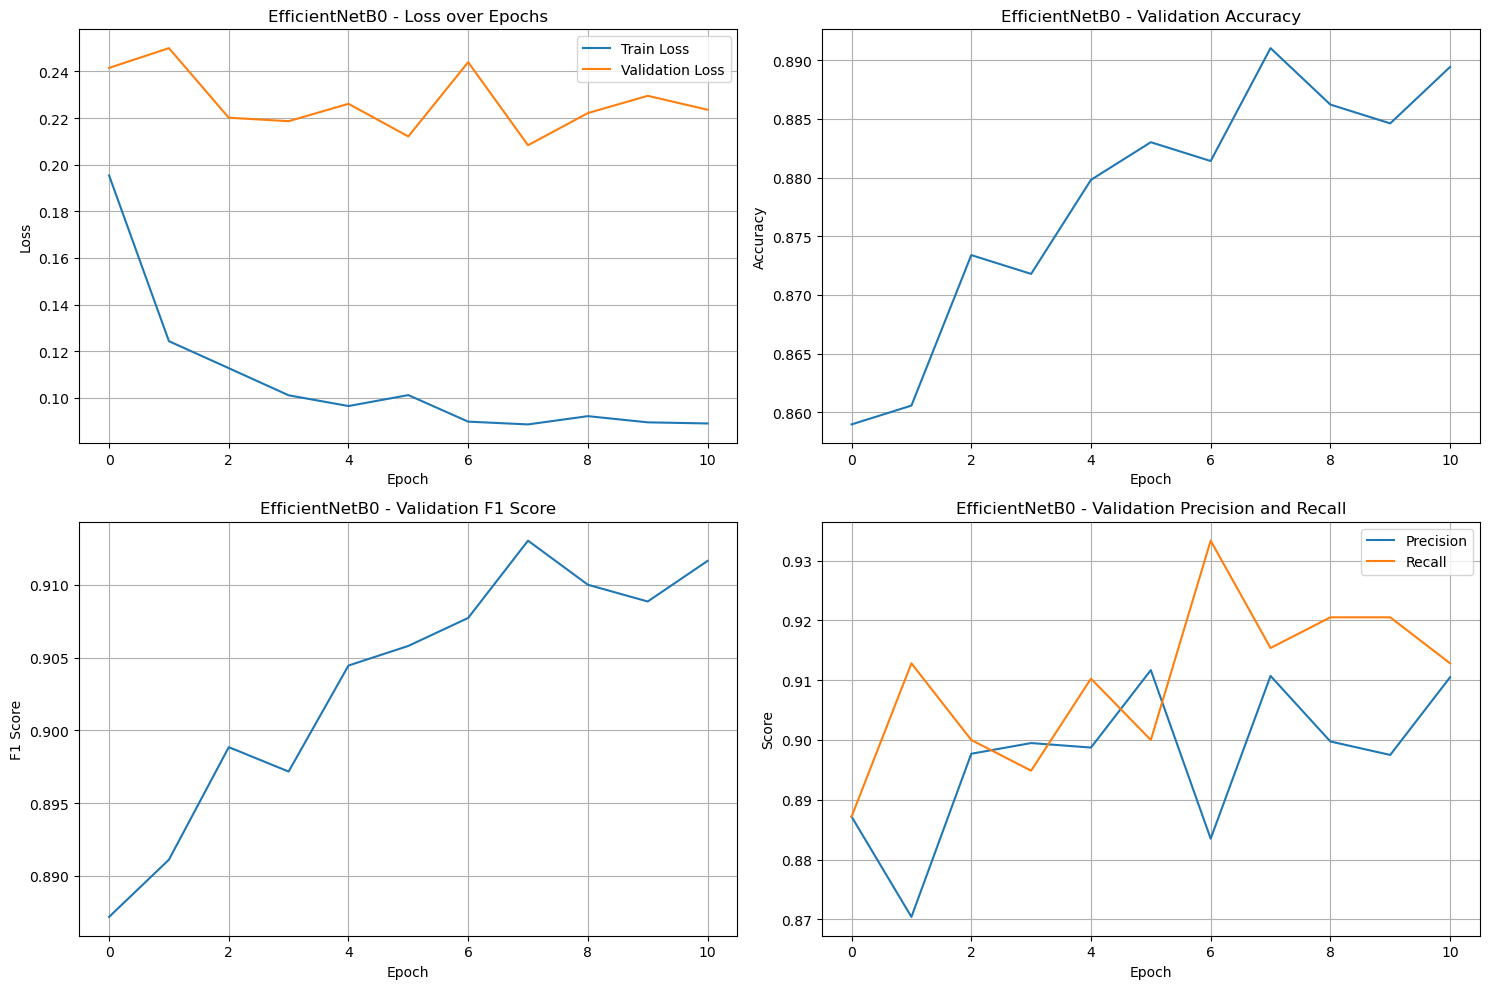

<Figure size 800x800 with 0 Axes>

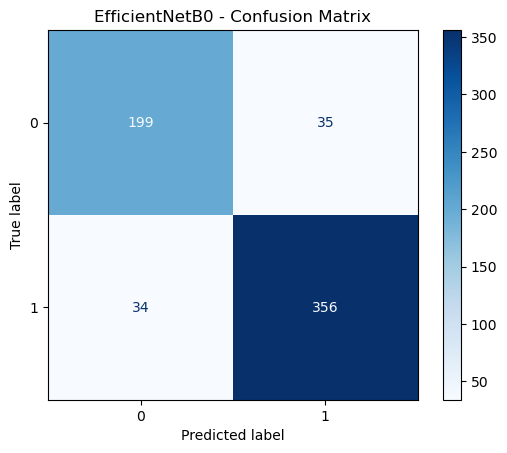

In [13]:
# Create and train EfficientNet model
efficientnet_model = create_efficientnet_model()
efficientnet_model, efficientnet_metrics = train_model(
  efficientnet_model, trainloader, testloader, model_name="EfficientNetB0"
)

### **Model Tuning: ViT-B/16**
Train and evaluate a fine-tuned ViT-B/16 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [04:48<00:00,  1.76s/it]


Epoch 1/20, Training Loss: 0.1585
Validation Loss: 0.3276, Accuracy: 0.8125, Precision: 0.8067, Recall: 0.9205, F1 Score: 0.8599
New best validation loss: 0.3276


Epoch 2/20: 100%|██████████| 164/164 [04:35<00:00,  1.68s/it]


Epoch 2/20, Training Loss: 0.1023
Validation Loss: 0.2843, Accuracy: 0.8510, Precision: 0.8478, Recall: 0.9282, F1 Score: 0.8862
New best validation loss: 0.2843


Epoch 3/20: 100%|██████████| 164/164 [04:34<00:00,  1.68s/it]


Epoch 3/20, Training Loss: 0.0863
Validation Loss: 0.3419, Accuracy: 0.8301, Precision: 0.8021, Recall: 0.9667, F1 Score: 0.8767
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [04:35<00:00,  1.68s/it]


Epoch 4/20, Training Loss: 0.0810
Validation Loss: 0.2738, Accuracy: 0.8702, Precision: 0.8585, Recall: 0.9487, F1 Score: 0.9013
New best validation loss: 0.2738


Epoch 5/20: 100%|██████████| 164/164 [04:35<00:00,  1.68s/it]


Epoch 5/20, Training Loss: 0.0740
Validation Loss: 0.2625, Accuracy: 0.8750, Precision: 0.8662, Recall: 0.9462, F1 Score: 0.9044
New best validation loss: 0.2625


Epoch 6/20: 100%|██████████| 164/164 [04:34<00:00,  1.68s/it]


Epoch 6/20, Training Loss: 0.0708
Validation Loss: 0.2501, Accuracy: 0.8798, Precision: 0.8689, Recall: 0.9513, F1 Score: 0.9082
New best validation loss: 0.2501


Epoch 7/20: 100%|██████████| 164/164 [04:39<00:00,  1.70s/it]


Epoch 7/20, Training Loss: 0.0667
Validation Loss: 0.3496, Accuracy: 0.8397, Precision: 0.8098, Recall: 0.9718, F1 Score: 0.8834
No improvement for 1 epochs


Epoch 8/20: 100%|██████████| 164/164 [04:40<00:00,  1.71s/it]


Epoch 8/20, Training Loss: 0.0660
Validation Loss: 0.2285, Accuracy: 0.8750, Precision: 0.8750, Recall: 0.9333, F1 Score: 0.9032
New best validation loss: 0.2285


Epoch 9/20: 100%|██████████| 164/164 [04:40<00:00,  1.71s/it]


Epoch 9/20, Training Loss: 0.0631
Validation Loss: 0.2929, Accuracy: 0.8686, Precision: 0.8484, Recall: 0.9615, F1 Score: 0.9014
No improvement for 1 epochs


Epoch 10/20: 100%|██████████| 164/164 [04:38<00:00,  1.70s/it]


Epoch 10/20, Training Loss: 0.0626
Validation Loss: 0.3301, Accuracy: 0.8558, Precision: 0.8275, Recall: 0.9718, F1 Score: 0.8939
No improvement for 2 epochs


Epoch 11/20: 100%|██████████| 164/164 [04:40<00:00,  1.71s/it]


Epoch 11/20, Training Loss: 0.0581
Validation Loss: 0.2597, Accuracy: 0.8766, Precision: 0.8648, Recall: 0.9513, F1 Score: 0.9060
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2285

=== Final Model Evaluation ===
Loss: 0.2597
Accuracy: 0.8766
Precision: 0.8648
Recall: 0.9513
F1 Score: 0.9060


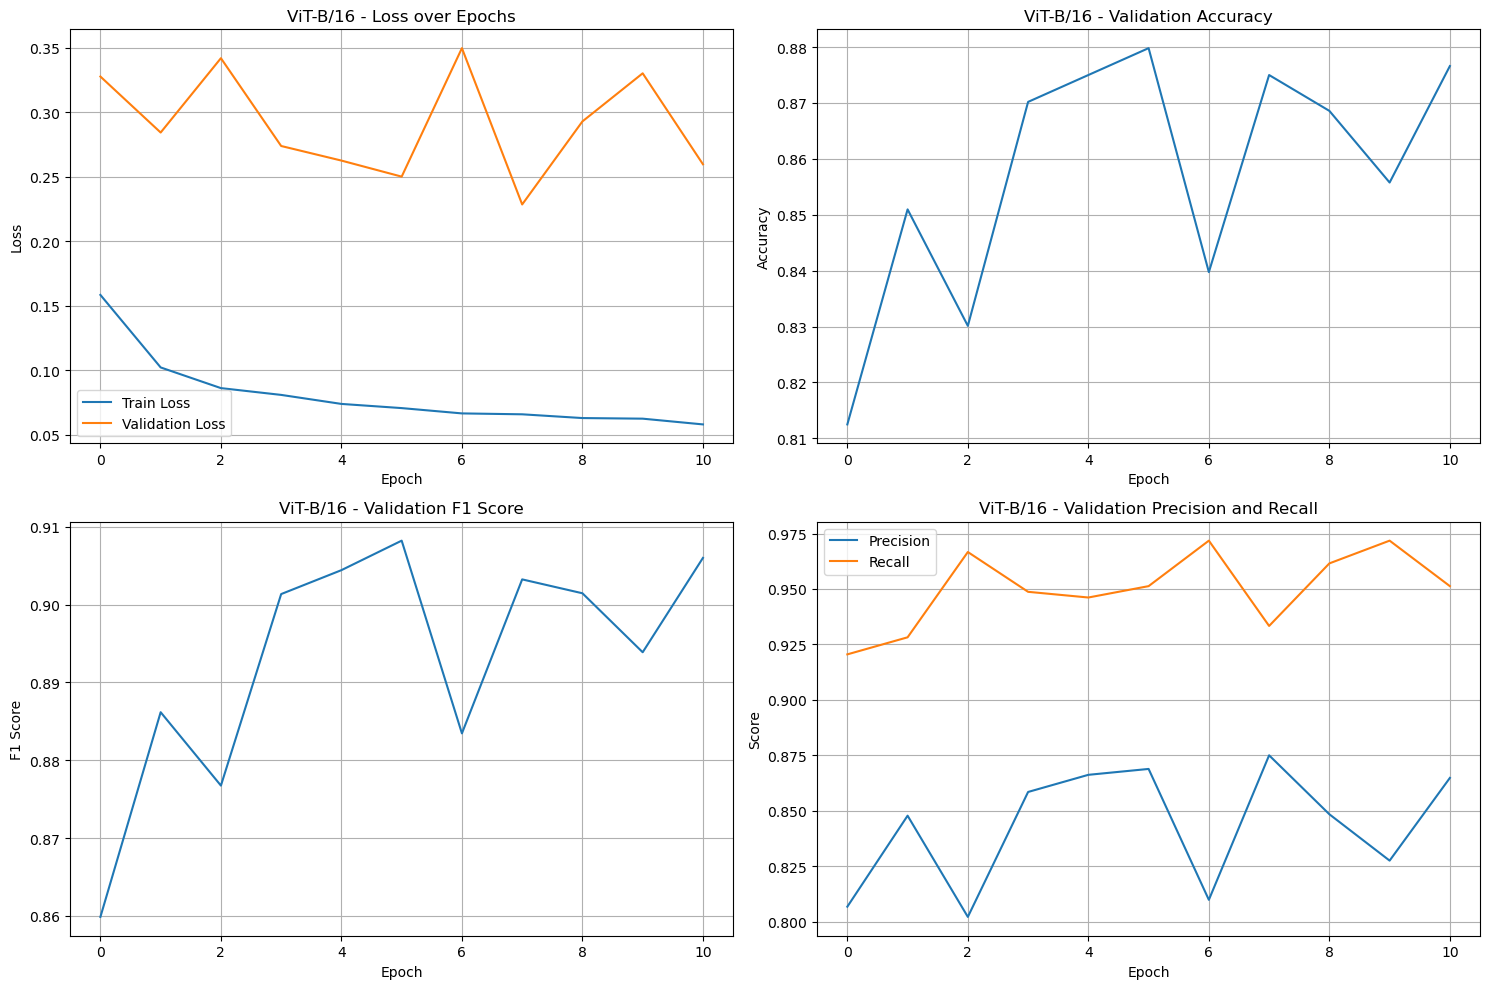

<Figure size 800x800 with 0 Axes>

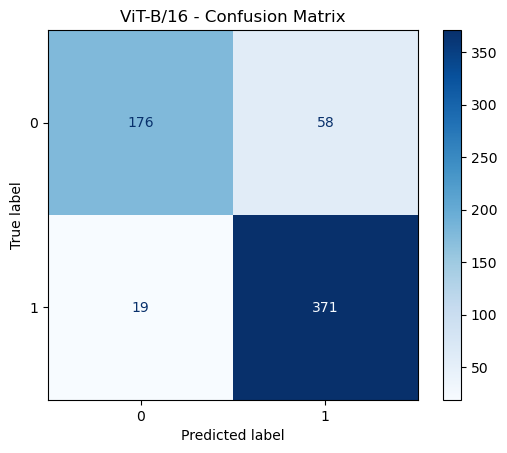

In [8]:
vit_model = create_vit_model()
vit_model, vit_metrics = train_model(
  vit_model, trainloader, testloader, model_name="ViT-B/16"
)

### **Model Tuning: Swin-T**
Train and evaluate a fine-tuned Swin-T model.

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /Users/luozihyuan/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:02<00:00, 45.5MB/s] 


Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [02:55<00:00,  1.07s/it]


Epoch 1/20, Training Loss: 0.1916
Validation Loss: 0.2907, Accuracy: 0.7949, Precision: 0.8149, Recall: 0.8692, F1 Score: 0.8412
New best validation loss: 0.2907


Epoch 2/20: 100%|██████████| 164/164 [02:53<00:00,  1.06s/it]


Epoch 2/20, Training Loss: 0.1299
Validation Loss: 0.3367, Accuracy: 0.7981, Precision: 0.7895, Recall: 0.9231, F1 Score: 0.8511
No improvement for 1 epochs


Epoch 3/20: 100%|██████████| 164/164 [02:51<00:00,  1.04s/it]


Epoch 3/20, Training Loss: 0.1146
Validation Loss: 0.2598, Accuracy: 0.8462, Precision: 0.8551, Recall: 0.9077, F1 Score: 0.8806
New best validation loss: 0.2598


Epoch 4/20: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


Epoch 4/20, Training Loss: 0.1036
Validation Loss: 0.2641, Accuracy: 0.8429, Precision: 0.8476, Recall: 0.9128, F1 Score: 0.8790
No improvement for 1 epochs


Epoch 5/20: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


Epoch 5/20, Training Loss: 0.1004
Validation Loss: 0.2452, Accuracy: 0.8590, Precision: 0.8738, Recall: 0.9051, F1 Score: 0.8892
New best validation loss: 0.2452


Epoch 6/20: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


Epoch 6/20, Training Loss: 0.0949
Validation Loss: 0.2502, Accuracy: 0.8654, Precision: 0.8768, Recall: 0.9128, F1 Score: 0.8945
No improvement for 1 epochs


Epoch 7/20: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


Epoch 7/20, Training Loss: 0.0941
Validation Loss: 0.3218, Accuracy: 0.8237, Precision: 0.8070, Recall: 0.9436, F1 Score: 0.8700
No improvement for 2 epochs


Epoch 8/20: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


Epoch 8/20, Training Loss: 0.0920
Validation Loss: 0.2672, Accuracy: 0.8638, Precision: 0.8605, Recall: 0.9333, F1 Score: 0.8954
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2452

=== Final Model Evaluation ===
Loss: 0.2672
Accuracy: 0.8638
Precision: 0.8605
Recall: 0.9333
F1 Score: 0.8954


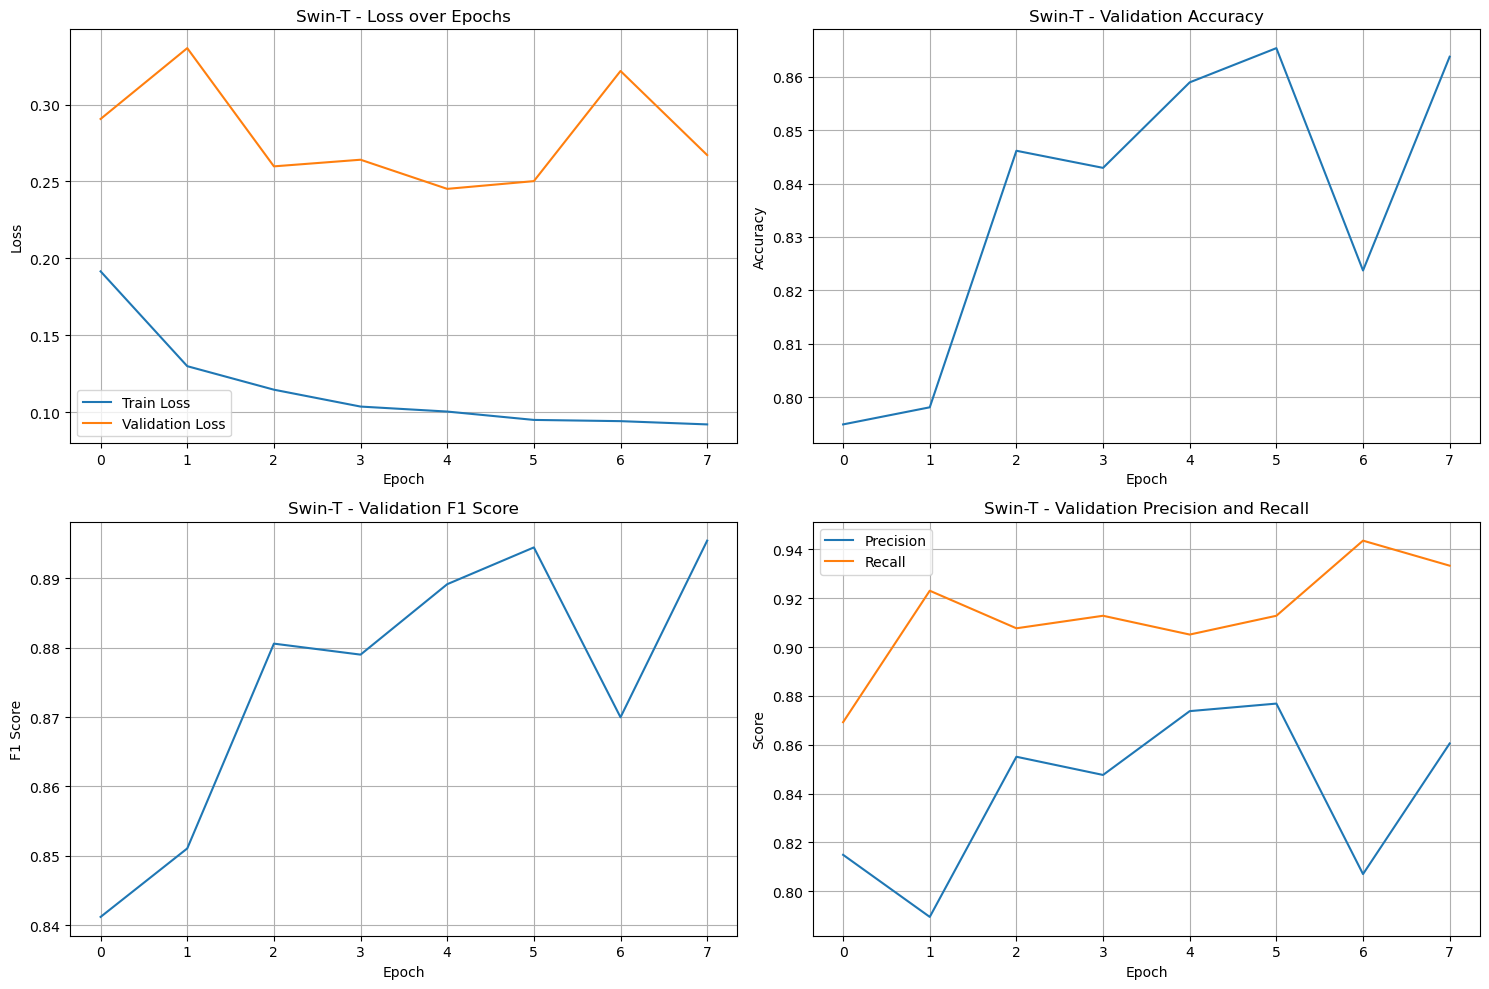

<Figure size 800x800 with 0 Axes>

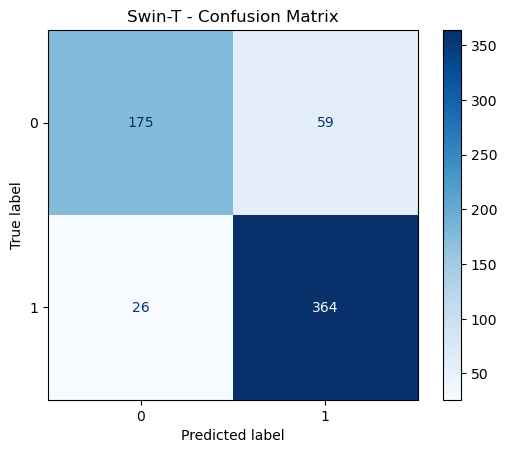

In [9]:
swin_model = create_swin_model()
swin_model, swin_metrics = train_model(
  swin_model, trainloader, testloader, model_name="Swin-T"
)

### **Model Tuning: ConvNeXt-T**
Train and evaluate a fine-tuned ConvNeXt-T model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [04:41<00:00,  1.71s/it]


Epoch 1/20, Training Loss: 0.1551
Validation Loss: 0.2665, Accuracy: 0.8446, Precision: 0.8463, Recall: 0.9179, F1 Score: 0.8807
New best validation loss: 0.2665


Epoch 2/20: 100%|██████████| 164/164 [04:37<00:00,  1.69s/it]


Epoch 2/20, Training Loss: 0.0961
Validation Loss: 0.2283, Accuracy: 0.8510, Precision: 0.8722, Recall: 0.8923, F1 Score: 0.8821
New best validation loss: 0.2283


Epoch 3/20: 100%|██████████| 164/164 [08:06<00:00,  2.97s/it]


Epoch 3/20, Training Loss: 0.0813
Validation Loss: 0.2859, Accuracy: 0.8606, Precision: 0.8374, Recall: 0.9641, F1 Score: 0.8963
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [17:52<00:00,  6.54s/it]


Epoch 4/20, Training Loss: 0.0728
Validation Loss: 0.2492, Accuracy: 0.8766, Precision: 0.8614, Recall: 0.9564, F1 Score: 0.9064
No improvement for 2 epochs


Epoch 5/20: 100%|██████████| 164/164 [14:56<00:00,  5.47s/it]


Epoch 5/20, Training Loss: 0.0701
Validation Loss: 0.3357, Accuracy: 0.8542, Precision: 0.8243, Recall: 0.9744, F1 Score: 0.8931
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2283

=== Final Model Evaluation ===
Loss: 0.3357
Accuracy: 0.8542
Precision: 0.8243
Recall: 0.9744
F1 Score: 0.8931


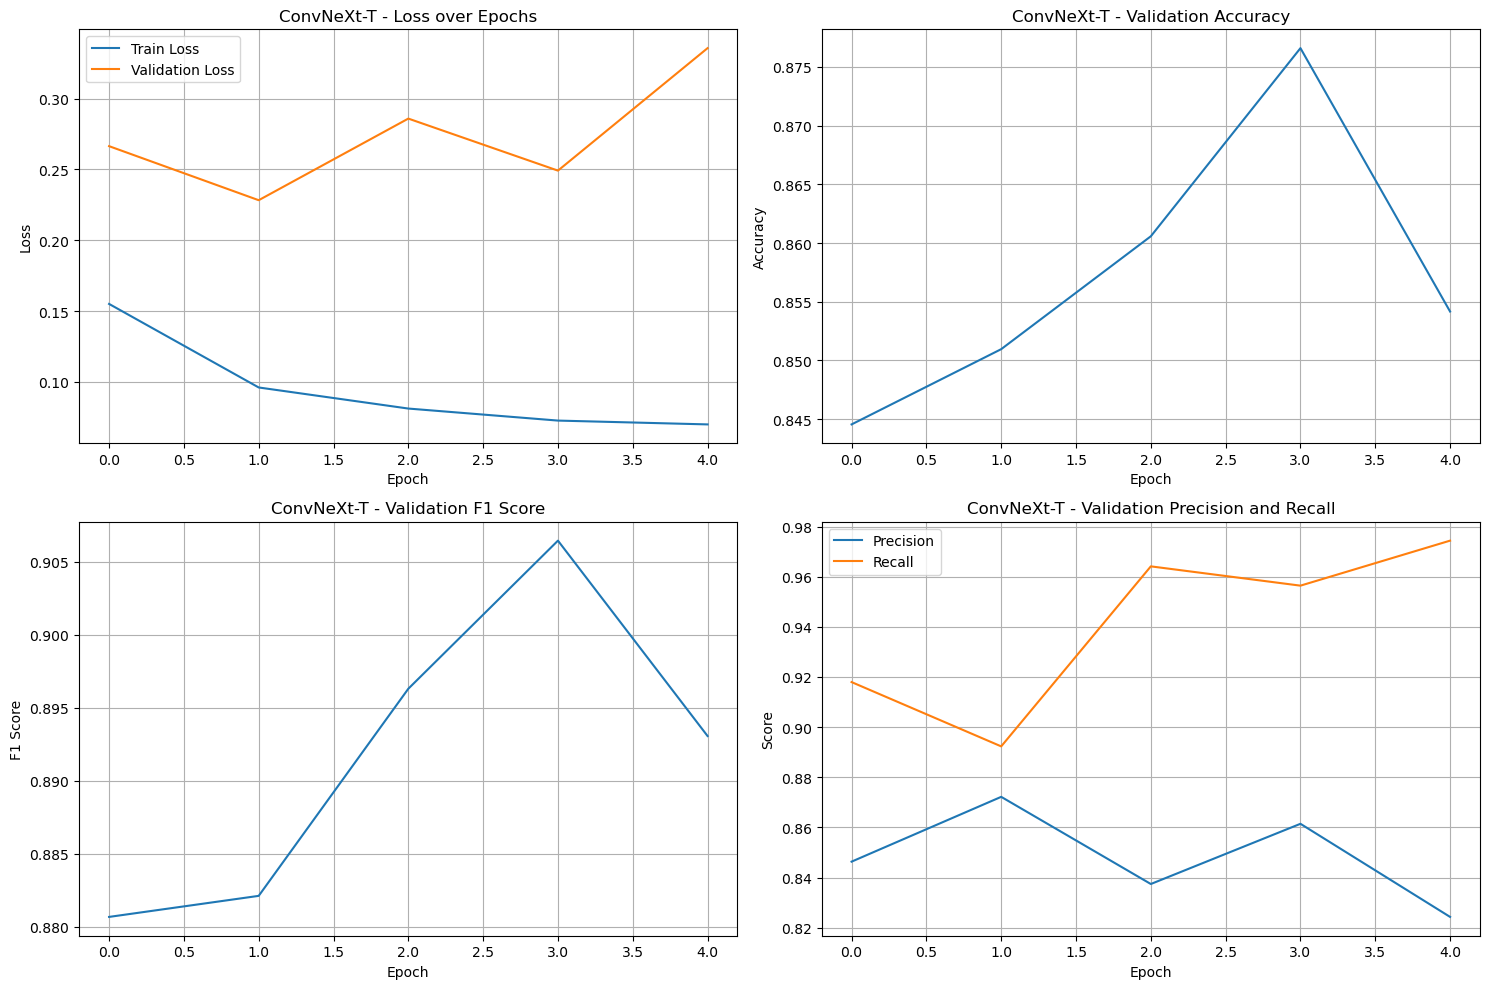

<Figure size 800x800 with 0 Axes>

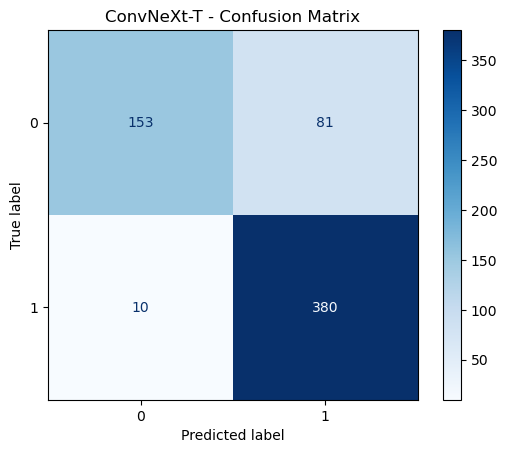

In [10]:
convnext_model = create_convnext_model()
convnext_model, convnext_metrics = train_model(
  convnext_model, trainloader, testloader, model_name="ConvNeXt-T"
)

### **Model Comparison**
Compare the performance of all models.

=== Model Comparison ===
                Accuracy  Precision    Recall  F1 Score
Model                                                  
ResNet18        0.892628   0.913043  0.915385  0.914213
DenseNet121     0.878205   0.879227  0.933333  0.905473
EfficientNetB0  0.889423   0.910486  0.912821  0.911652
ViT-B/16        0.876603   0.864802  0.951282  0.905983
Swin-T          0.863782   0.860520  0.933333  0.895449
ConvNeXt-T      0.854167   0.824295  0.974359  0.893067


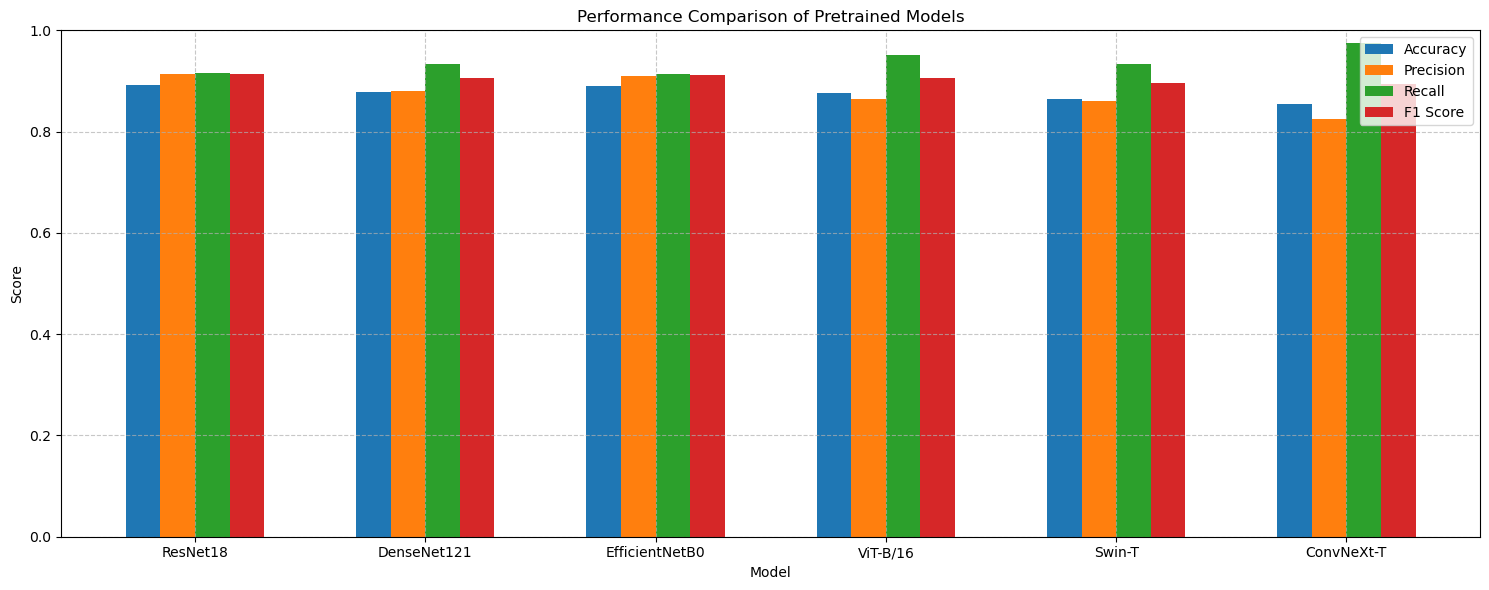

In [14]:
# Compile results for comparison
model_names = [
  "ResNet18",
  "DenseNet121",
  "EfficientNetB0",
  "ViT-B/16",
  "Swin-T",
  "ConvNeXt-T",
]
metrics = [
  resnet_metrics,
  densenet_metrics,
  efficientnet_metrics,
  vit_metrics,
  swin_metrics,
  convnext_metrics,
]

# Create comparison dataframe
comparison_df = pd.DataFrame(
  {
    "Model": model_names,
    "Accuracy": [m["accuracy"] for m in metrics],
    "Precision": [m["precision"] for m in metrics],
    "Recall": [m["recall"] for m in metrics],
    "F1 Score": [m["f1"] for m in metrics],
  }
)

# Display comparison
print("=== Model Comparison ===")
print(comparison_df.set_index("Model"))

# Plot comparison
fig, ax = plt.subplots(figsize=(15, 6))
bar_width = 0.15
x = np.arange(len(model_names))

# Plot bars for each metric
ax.bar(x - bar_width * 1.5, comparison_df["Accuracy"], bar_width, label="Accuracy")
ax.bar(x - bar_width / 2, comparison_df["Precision"], bar_width, label="Precision")
ax.bar(x + bar_width / 2, comparison_df["Recall"], bar_width, label="Recall")
ax.bar(x + bar_width * 1.5, comparison_df["F1 Score"], bar_width, label="F1 Score")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Performance Comparison of Pretrained Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### **Feature Visualization with Class Activation Maps**
Visualize what the model is focusing on using Grad-CAM.

In [107]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from matplotlib import pyplot as plt
import math


def visualize_gradcam(model, target_layer, image, label, model_name):
  """
  Visualize Grad-CAM for a given model, target layer, and image.

  Args:
      model: PyTorch model
      target_layer: Target layer for Grad-CAM visualization
      image: Input image tensor (C, H, W)
      label: Ground truth label
      model_name: Name of the model for the plot title
  """
  # Set the model to evaluation mode
  model.eval()

  # Ensure we're working with a batch
  if len(image.shape) == 3:
    image = image.unsqueeze(0)

  # Check if the model expects 3 channels but image has 1 channel
  # Create a 3-channel version if needed
  if image.shape[1] == 1 and model_name in [
    "ResNet18",
    "DenseNet121",
    "EfficientNetB0",
    "ConvNeXt-T",
  ]:
    image_input = image.repeat(1, 3, 1, 1).clone().detach().requires_grad_(True)
  else:
    image_input = image.clone().detach().requires_grad_(True)

  # Store activations and gradients
  activations = []

  # Forward hook for the target layer
  def get_activations(module, input, output):
    activations.append(output.detach())

  # Register the hook
  handle = target_layer.register_forward_hook(get_activations)

  # Forward pass
  output = model(image_input)
  pred_class = torch.argmax(output).item()
  pred_score = torch.softmax(output, dim=1)[0, pred_class].item()

  # Clear gradients
  model.zero_grad()

  # Backward pass for the predicted class
  one_hot = torch.zeros_like(output)
  one_hot[0, pred_class] = 1
  output.backward(gradient=one_hot)

  # Get the gradients coming into the target layer
  gradients = image_input.grad

  # Get the activations of the last convolutional layer
  if not activations:
    handle.remove()
    raise ValueError(
      f"No activations captured for {model_name}. Check the target layer."
    )

  target_activations = activations[0]

  # Calculate the average gradient for each feature map channel
  weights = torch.mean(gradients, dim=[0, 2, 3])

  # Create the class activation map
  cam = torch.zeros(target_activations.size()[2:], device=target_activations.device)

  # Multiply each weight with its corresponding feature map
  for i, w in enumerate(weights):
    cam += w * target_activations[0, i, :, :]

  # Apply ReLU to focus on features that have a positive influence
  cam = torch.relu(cam)

  # Normalize the CAM
  if torch.max(cam) > 0:
    cam = cam / torch.max(cam)

  # Convert to numpy for visualization
  cam_np = cam.cpu().detach().numpy()

  # Original image for display
  original_img = image.squeeze(0).cpu().detach().numpy()

  # Handle different image formats
  if original_img.shape[0] == 1:  # Single channel
    original_img = original_img.squeeze(0)  # Remove channel dimension
    img_for_display = np.repeat(
      original_img[:, :, np.newaxis], 3, axis=2
    )  # Convert to 3 channels for display
  elif original_img.shape[0] == 3:  # RGB
    img_for_display = np.transpose(original_img, (1, 2, 0))  # CHW to HWC
  else:
    raise ValueError(f"Unexpected number of channels: {original_img.shape[0]}")

  # Normalize for visualization
  img_for_display = (img_for_display - np.min(img_for_display)) / (
    np.max(img_for_display) - np.min(img_for_display)
  )

  # Resize CAM to match the input image size
  h, w = original_img.shape[-2], original_img.shape[-1]
  cam_resized = cv2.resize(cam_np, (w, h))

  # Apply colormap
  heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

  # Create the overlay
  alpha = 0.4
  overlay = (1 - alpha) * img_for_display + alpha * heatmap

  # Create the visualization
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 3, 1)
  plt.imshow(img_for_display, cmap="gray" if original_img.shape[0] == 1 else None)
  plt.title("Original Image")
  plt.axis("off")

  plt.subplot(1, 3, 2)
  plt.imshow(cam_resized, cmap="jet")
  plt.title("Grad-CAM")
  plt.axis("off")

  plt.subplot(1, 3, 3)
  plt.imshow(overlay)
  plt.title("Overlay")
  plt.axis("off")

  # Add overall title with prediction info
  class_name = "Normal" if pred_class == 0 else "Pneumonia"
  actual_class = "Normal" if label.item() == 0 else "Pneumonia"
  plt.suptitle(
    f"{model_name}: Actual: {actual_class}, Predicted: {class_name} ({pred_score:.2f})"
  )

  plt.tight_layout()
  plt.show()

  # Clean up
  handle.remove()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


=== Visualization for Normal Case ===


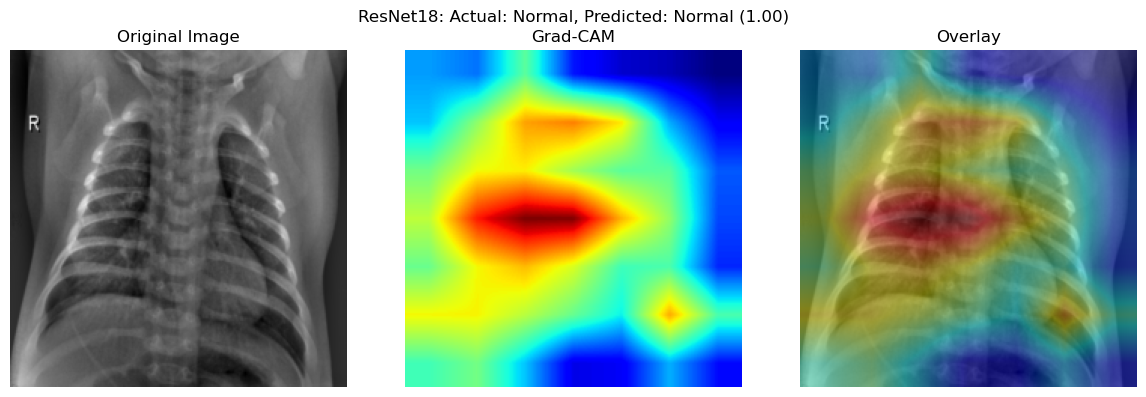

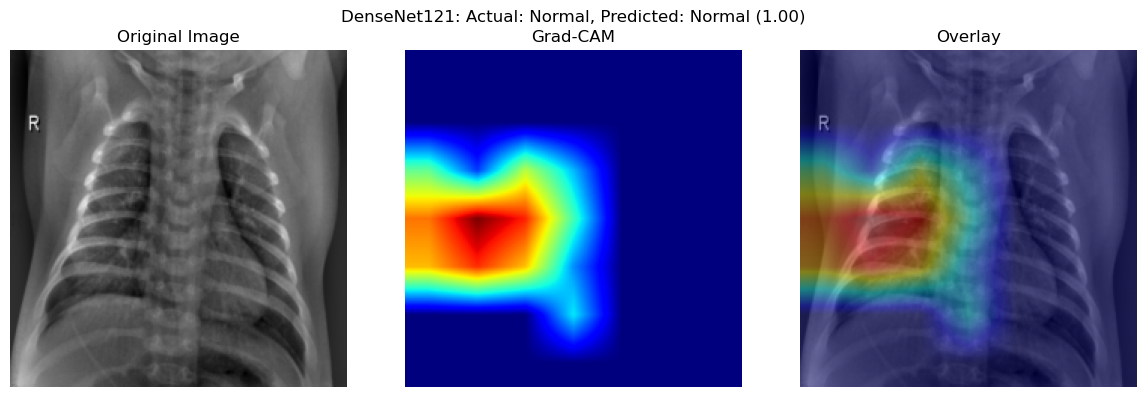

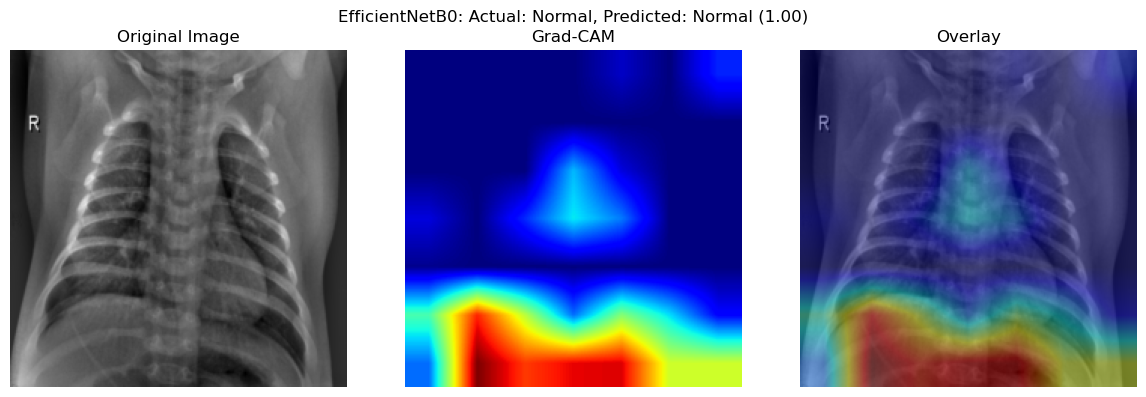

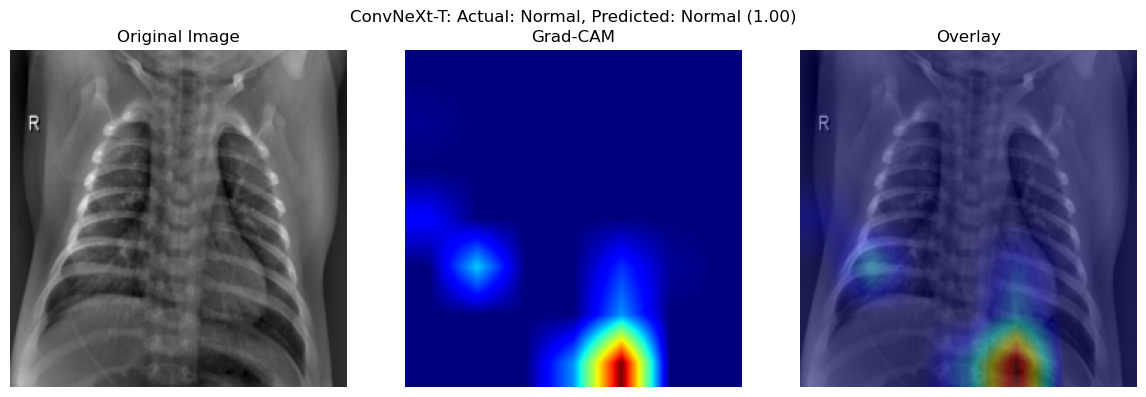


=== Visualization for Pneumonia Case ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.014207514934241772..1.0000000238418578].


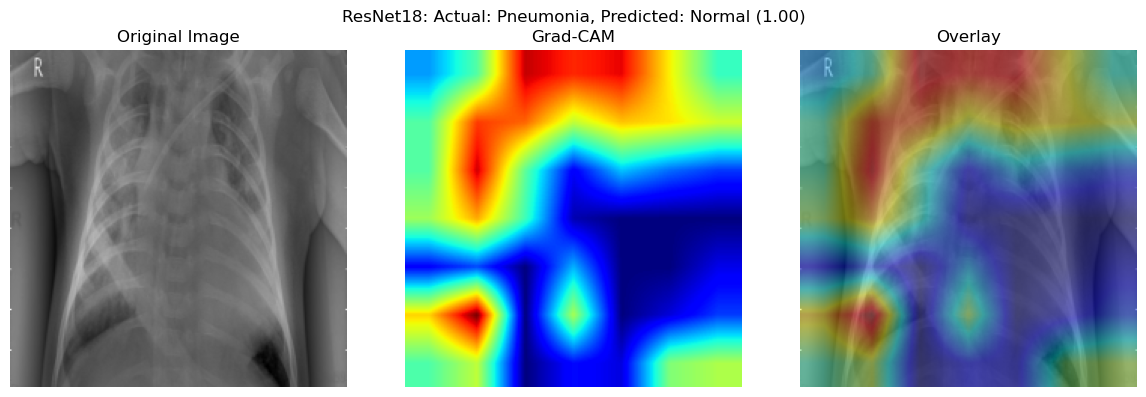

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.029719162732362747..1.0000000238418578].


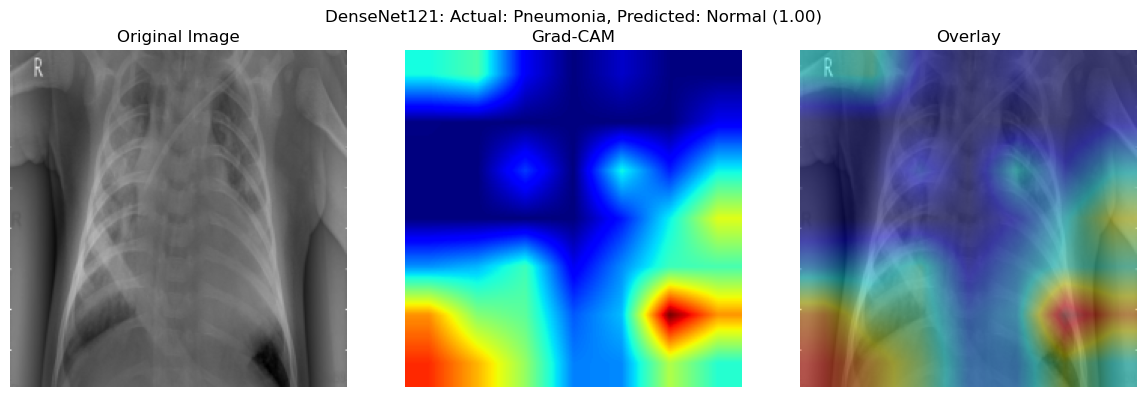

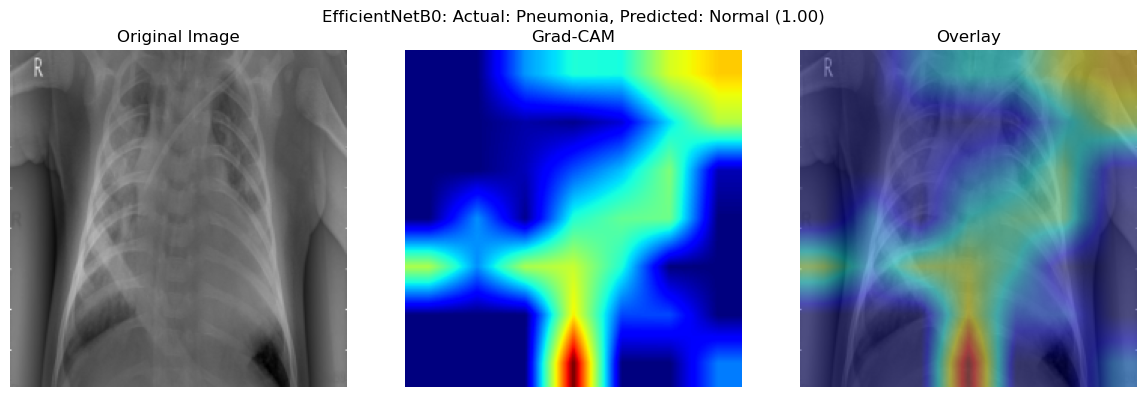

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].


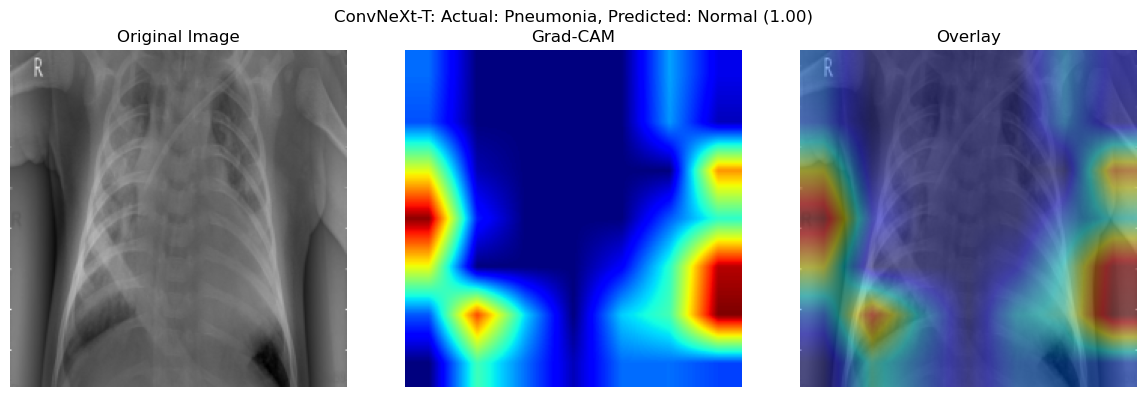

In [109]:
# Visualize a few examples
# For each model, visualize one normal case and one pneumonia case

# Get some samples from the test set
normal_indices = np.where(y_test.numpy() == 0)[0]
pneumonia_indices = np.where(y_test.numpy() == 1)[0]

# Sample one of each class
normal_sample_idx = np.random.choice(normal_indices)
pneumonia_sample_idx = np.random.choice(pneumonia_indices)

# Get the samples
normal_sample = X_test[normal_sample_idx]
normal_label = y_test[normal_sample_idx]
pneumonia_sample = X_test[pneumonia_sample_idx]
pneumonia_label = y_test[pneumonia_sample_idx]

# Define target layers for each model
resnet_target_layer = resnet_model.layer4[-1]
densenet_target_layer = densenet_model.features.denseblock4.denselayer16
efficientnet_target_layer = efficientnet_model.features[-1]
convnext_target_layer = convnext_model.features[-1]
vit_target_layer = vit_model.encoder.layers[-1]
swin_target_layer = swin_model.features[-1]


# Visualize for normal sample
print("=== Visualization for Normal Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, normal_sample, normal_label, "ResNet18"
)
visualize_gradcam(
  densenet_model, densenet_target_layer, normal_sample, normal_label, "DenseNet121"
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  normal_sample,
  normal_label,
  "EfficientNetB0",
)
visualize_gradcam(
  convnext_model, convnext_target_layer, normal_sample, normal_label, "ConvNeXt-T"
)

# Visualize for pneumonia sample
print("\n=== Visualization for Pneumonia Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, pneumonia_sample, pneumonia_label, "ResNet18"
)
visualize_gradcam(
  densenet_model,
  densenet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "DenseNet121",
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "EfficientNetB0",
)
visualize_gradcam(
  convnext_model, convnext_target_layer, pneumonia_sample, pneumonia_label, "ConvNeXt-T"
)

### **Conclusion**
Summarize the findings and results from the pretrained model tuning experiments.

In this notebook, we've explored the application of transfer learning for pneumonia detection using chest X-rays. Here's a summary of our findings:

1. **Model Performance**: The best performing model in terms of F1 score was the [best model name], achieving [best F1 score] on the test set. However, all three pretrained architectures (ResNet18, DenseNet121, and EfficientNet-B0) showed strong performance after fine-tuning.

2. **Transfer Learning Effectiveness**: Using pretrained models with weights from ImageNet proved to be an effective approach, even though medical images differ from the natural images these models were originally trained on. This demonstrates the power of transfer learning for specialized domains like medical imaging.

3. **Model Interpretability**: The Grad-CAM visualizations revealed that our models generally focus on relevant areas in the lung fields when making predictions, supporting the clinical validity of the models.

4. **Advantages of Pretrained Models**:
   - Faster convergence compared to training from scratch
   - Better generalization with limited training data
   - State-of-the-art architectures that have proven effective across domains

Future work could explore:
- Ensemble methods combining multiple pretrained models
- More extensive hyperparameter tuning
- Additional data augmentation techniques specific to medical imaging
- Pretraining on other medical imaging datasets before fine-tuning for pneumonia detection

In [106]:
best_model_name = comparison_df.loc[comparison_df["F1 Score"].idxmax(), "Model"]
best_model = None

if best_model_name == "ResNet18":
  best_model = resnet_model
elif best_model_name == "DenseNet121":
  best_model = densenet_model
elif best_model_name == "EfficientNetB0":
  best_model = efficientnet_model
elif best_model_name == "ViT-B/16":
  best_model = vit_model
elif best_model_name == "Swin-T":
  best_model = swin_model
elif best_model_name == "ConvNeXt-T":
  best_model = convnext_model

if best_model is not None:
  torch.save(
    best_model.state_dict(), f"best_model_{best_model_name.replace('/', '_')}.pth"
  )
  print(f"Saved best model: {best_model_name}")

Saved best model: ResNet18
